First download and extract [this zipfile from the Omniglot dataset](https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip) into the same folder holding the noteboook. This will create a folder `images_background` containing a hierarchy of folders for alphabets and characters, with each leaf folder containing several hand-drawn images of that character.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import random

First load the dataset. We'll just load all images as matrix of black and white pixel values, and store for each instance the alphabet which will serve as the class label.

In [3]:
img_dir = '..\images_background'
images = []
labels = []
for alphabet_name in os.listdir(img_dir):
    if alphabet_name[0] == '.': continue
        
    alphabet_dir = os.path.join(img_dir,alphabet_name)
    for char_name in os.listdir(alphabet_dir):
        if char_name[0] == '.': continue
            
        char_dir = os.path.join(img_dir, alphabet_name, char_name)
        for img_fname in os.listdir(char_dir):
            if img_fname[0] == '.': continue
                
            img = np.array(Image.open(os.path.join(char_dir,img_fname)), dtype=bool)
            images.append(img)
            labels.append(alphabet_name)

print('Loaded', len(images), 'images with', len(set(labels)), 'unique labels')

Loaded 19280 images with 30 unique labels


Display some of the images, to get a feel for the dataset.

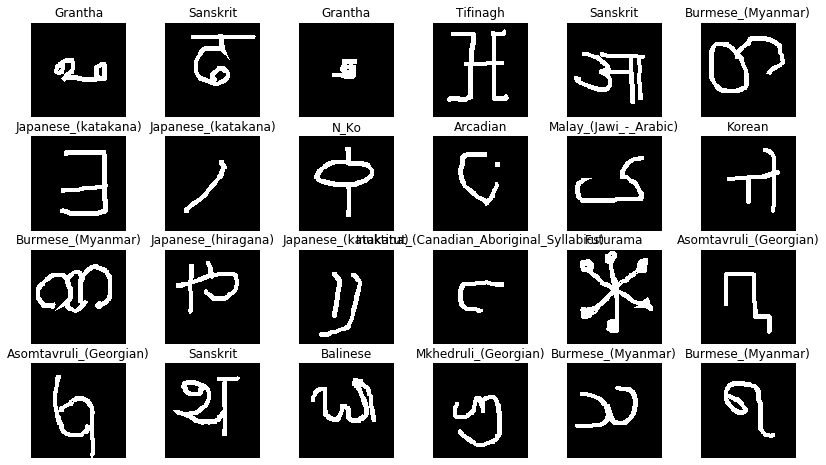

In [4]:
_, axes = plt.subplots(nrows=4, ncols=6, figsize=(14, 8))
for axr in axes:
    for ax in axr: 
        ax.set_axis_off()
        i = random.randint(0,len(images))
        ax.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f'{labels[i]}')

Embeds the images using a pre-trained vision model. This will reduce the size of feature representation from 105x105 binary values to a vector of 1000 real values. There are other ways in which the images can be converted to feature representations, e.g., by flattening the images to 11k vectors,  by processing the original inputs using a convolutional network, applying a method for dimensionality reduction, etc. What you do at this step, if anything, is up to you.

In [5]:
from PIL import Image
import torch
from torchvision import models, transforms as T
from torch.utils.data import BatchSampler, SequentialSampler
from tqdm import tqdm
from os.path import exists

# preprocessing pipeline to transform image into input image format 
# required by torchvision pretrained models
preprocess = T.Compose([
    T.Resize(224),
    T.Grayscale(3),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# use one of the smaller ResNet models (NB there are dozens others to choose from)
model = models.resnet18(pretrained=True)
model.eval()

# process each image by transforming then embedding in small batches
# this takes 20 mins or so
with torch.no_grad():
    embedded_images = []
    for bids in tqdm(BatchSampler(SequentialSampler(range(len(images))), 
                                  batch_size=64, drop_last=False)):
        bx = [preprocess(Image.fromarray(images[b])) for b in bids]
        embedded_images.append(model(torch.stack(bx)))  

    embedded_images = torch.cat(embedded_images)
    torch.save(embedded_images, 'embedded.pt')

embedded_images.shape

  3%|▎         | 8/302 [00:19<12:11,  2.49s/it]

KeyboardInterrupt: 

In [ ]:
np.save('images.npy', embedded_images.numpy())
np.save('labels.npy', labels)